In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/cifar_data')
try:
  os.makedirs(local_download_path)
except: pass

file_id = '1ooLs3AoMQTXfk1seDE6ZwAIKYZLqoAUb'

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
#file_lists = [drive.ListFile({'q': "{} in parents".format('{}'.format(oneid))}).GetList() for oneid in ids]

file_lists = []
file_list = drive.ListFile({'q': "'{}' in parents".format(file_id)}).GetList()
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


#with open(fname, 'r') as f:
#  print(f.read())

title: cifar-10-python.tar.gz, id: 1cM4qrBO86bbmLAYjET7cQKqOYGl9ZIhr
downloading to /content/cifar_data/cifar-10-python.tar.gz


In [0]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import io
import glob
import random
import tensorflow as tf
import tarfile

In [3]:
os.path.expanduser('~/cifar_data')
tar_path = '{}/cifar-10-python.tar.gz'.format(local_download_path)
tar_path
os.listdir(local_download_path)

['cifar-10-python.tar.gz', 'cifar-10-batches-py']

In [0]:
tar = tarfile.open(tar_path)
tar.extractall(path = local_download_path)
tar.close()


In [5]:
train_batch_files = glob.glob("{}/cifar-10-batches-py/data_batch_*".format(local_download_path))
train_batch_files
test_batch_file = glob.glob("{}/cifar-10-batches-py/test_batch".format(local_download_path))[0]
test_batch_file

'/content/cifar_data/cifar-10-batches-py/test_batch'

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [24]:
train_dicts = [unpickle(file) for file in train_batch_files]
test_dict = unpickle(test_batch_file)
len(train_dicts[0][b'labels'])
test_dict

{b'batch_label': b'testing batch 1 of 1',
 b'data': array([[158, 159, 165, ..., 124, 129, 110],
        [235, 231, 232, ..., 178, 191, 199],
        [158, 158, 139, ...,   8,   3,   7],
        ...,
        [ 20,  19,  15, ...,  50,  53,  47],
        [ 25,  15,  23, ...,  80,  81,  80],
        [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8),
 b'filenames': [b'domestic_cat_s_000907.png',
  b'hydrofoil_s_000078.png',
  b'sea_boat_s_001456.png',
  b'jetliner_s_001705.png',
  b'green_frog_s_001658.png',
  b'crapaud_s_002124.png',
  b'shooting_brake_s_000973.png',
  b'green_frog_s_000634.png',
  b'tabby_cat_s_001397.png',
  b'wagon_s_002806.png',
  b'plane_s_000026.png',
  b'dustcart_s_000045.png',
  b'toy_spaniel_s_001592.png',
  b'lippizan_s_000752.png',
  b'truck_s_000149.png',
  b'dredger_s_001437.png',
  b'puppy_s_001937.png',
  b'cow_pony_s_000038.png',
  b'boat_s_001450.png',
  b'rana_clamitans_s_000570.png',
  b'tennessee_walker_s_000353.png',
  b'stealth_fighter_s_000354.png',

In [0]:
def extract_image(arr):
  image = [[[arr[1024*i + 32*j + k] for i in range(3)] for k in range(32)] for j in range(32)]
  return np.array(image)

def generate_one_hot(label):
  assert(label < 10 and label >= 0)
  one_hot = [(lambda i: int(i == label))(i) for i in range(10) ]
  return np.array(one_hot)



In [0]:

def get_batch_and_labels(batch_size, dict_ind, img_ctr, max_imgs):
  batch = []
  labels = []  
  for i in range(batch_size):
    if(img_ctr >= max_imgs):
      img_ctr = 0
      dict_ind += 1      
      if(dict_ind >= 5):
        dict_ind = 0   
    batch.append(extract_image(train_dicts[dict_ind][b'data'][img_ctr]))
    labels.append(generate_one_hot(train_dicts[dict_ind][b'labels'][img_ctr]))    
    img_ctr += 1  
  return np.array(batch), np.array(labels), dict_ind, img_ctr


def get_test_batch_and_labels():
  batch = []
  labels = []
  for data,label in zip(test_dict[b'data'],test_dict[b'labels']):
    img = extract_image(data)
    one_hot = generate_one_hot(label)
    batch.append(img)
    labels.append(one_hot)
  return np.array(batch), np.array(labels)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

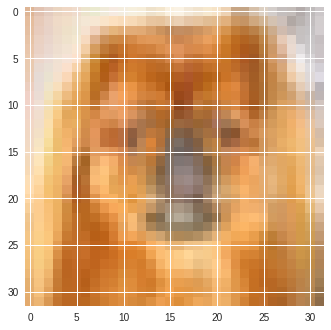

In [129]:
batch, labels, d, i = get_batch_and_labels(200,2,9900,10000)
plt.imshow(batch[153])
labels[153]

In [0]:
n_epochs = 2000
minibatch_size = 20
lr = 1e-4
keep = 0.5

In [0]:
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])

y_ = tf.placeholder(tf.float32, shape = [None, 10])

In [0]:
def weight_variable(shape):
    """Initializes weights randomly from a normal distribution
    Params: shape: list of dimensionality of the tensor to be initialized
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Initializes the bias term randomly from a normal distribution.
    Params: shape: list of dimensionality for the bias term.
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    """Performs a convolution over a given patch x with some filter W.
    Uses a stride of length 1 and SAME padding (padded with zeros at the edges)
    Params:
    x: tensor: the image to be convolved over
    W: the kernel (tensor) with which to convolve.
    """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# strides is a length-4 list that specifies the amount to move for each dimension of our input x. 
# the dimensions correspond to the following (in order): batch_size, length of image, width of image, # of channels in image

def max_pool_2x2(x):
    """Performs a max pooling operation over a 2 x 2 region"""
    # ksize: we only want to take the maximum over 1 example and 1 channel. 
    # the middle elements are 2 x 2 because we want to take maxima over 2 x 2 regions
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME') # stride 2 right and 2 down

In [117]:
W_conv1 = weight_variable([5, 5, 3, 32]) # 5 x 5 kernel, across an image with 3 channels to 32 channels
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
#h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
#h_pool1
h_conv1

<tf.Tensor 'Relu_39:0' shape=(?, 32, 32, 32) dtype=float32>

In [118]:
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool2

<tf.Tensor 'MaxPool_17:0' shape=(?, 16, 16, 64) dtype=float32>

In [119]:
W_conv3 = weight_variable([5, 5, 64, 64]) 
b_conv3 = bias_variable([64])
h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)
#h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
#h_pool3
h_conv3

<tf.Tensor 'Relu_41:0' shape=(?, 16, 16, 64) dtype=float32>

In [104]:
W_conv4 = weight_variable([3, 3, 64, 128]) 
b_conv4 = bias_variable([128])
h_conv4 = tf.nn.relu(tf.nn.conv2d(h_conv3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4)
h_pool4 = tf.nn.max_pool(h_conv4, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool4

<tf.Tensor 'MaxPool_16:0' shape=(?, 8, 8, 128) dtype=float32>

In [81]:
W_conv5 = weight_variable([3, 3, 256, 512]) 
b_conv5 = bias_variable([512])
h_conv5 = tf.nn.relu(tf.nn.conv2d(h_pool4, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5)
#h_pool5 = tf.nn.max_pool(h_conv5, ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1], padding='SAME')
#h_pool5
h_conv5

<tf.Tensor 'Relu_24:0' shape=(?, 8, 8, 512) dtype=float32>

In [82]:
W_conv6 = weight_variable([3, 3, 512, 1024])
b_conv6 = bias_variable([1024])
h_conv6 = tf.nn.relu(tf.nn.conv2d(h_conv5, W_conv6, strides=[1, 1, 1, 1], padding='SAME') + b_conv6)
h_pool6 = tf.nn.max_pool(h_conv6, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool6

<tf.Tensor 'MaxPool_12:0' shape=(?, 4, 4, 1024) dtype=float32>

In [39]:
W_conv7 = weight_variable([3, 3, 128, 256]) 
b_conv7 = bias_variable([256])
h_conv7 = tf.nn.relu(tf.nn.conv2d(h_pool6, W_conv7, strides=[1, 1, 1, 1], padding='SAME') + b_conv7)
#h_pool7 = tf.nn.max_pool(h_conv7, ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1], padding='SAME')
#h_pool7
h_conv7

<tf.Tensor 'Relu_6:0' shape=(?, 4, 4, 256) dtype=float32>

In [0]:
W_conv8 = weight_variable([3, 3, 512, 512]) 
b_conv8 = bias_variable([512])
h_conv8 = tf.nn.relu(tf.nn.conv2d(h_pool7, W_conv8, strides=[1, 1, 1, 1], padding='SAME') + b_conv8)
h_pool8 = tf.nn.max_pool(h_conv8, ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1], padding='SAME')
h_pool8

<tf.Tensor 'MaxPool_76:0' shape=(?, 25, 25, 512) dtype=float32>

In [0]:
W_conv9 = weight_variable([3, 3, 512, 1024]) 
b_conv9 = bias_variable([1024])
h_conv9 = tf.nn.relu(tf.nn.conv2d(h_pool8, W_conv9, strides=[1, 2, 2, 1], padding='SAME') + b_conv9)
h_pool9 = tf.nn.max_pool(h_conv9, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool9

<tf.Tensor 'MaxPool_77:0' shape=(?, 7, 7, 1024) dtype=float32>

In [0]:
W_fc1 = weight_variable([8 * 8 * 128, 384]) 
b_fc1 = bias_variable([384])
h_conv_flat = tf.reshape(h_pool4, [-1, 8 * 8 * 128])
h_fc1 = tf.nn.relu(tf.matmul(h_conv_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [0]:
W_fc2 = weight_variable([384, 192])
b_fc2 = bias_variable([192])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [0]:
W_fc3 = weight_variable([192, 10])
b_fc3 = bias_variable([10])
y_out = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

In [0]:
#num_ep_per_dec = 350
#decay_steps = int(minibatch_size * num_ep_per_dec)
#global_step = tf.train.get_or_create_global_step()

#lr = tf.train.exponential_decay(0.1, global_step, decay_steps,0.1, staircase=True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_out, labels = y_)
#opt = tf.train.GradientDescentOptimizer(lr)
#grads = opt.compute_gradients(cross_entropy)
#apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

train_step = tf.train.AdagradOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_, axis = 1), tf.argmax(y_out, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

In [134]:
img_ctr = 0
dict_ind = 0
images_per_file = 10000
with tf.Session() as sess:
  sess.run(init)
  for i in range(n_epochs):
    training_inputs, training_labels, dict_ind, img_ctr = get_batch_and_labels(minibatch_size, dict_ind, img_ctr, images_per_file)    
    if i % 100 == 0:
      print("epoch:{} dict:{} img:{}".format(i,dict_ind, img_ctr))
      #print(img_ctrs)
      #print(training_labels)
      train_acc = accuracy.eval(feed_dict = {x: training_inputs, y_: training_labels, keep_prob : 1.0})
      print("training accuracy: {}".format(train_acc))
    sess.run([train_step], feed_dict = {x: training_inputs, y_: training_labels, keep_prob : keep})
  test_inputs, test_labels = get_test_batch_and_labels();
  test_acc = accuracy.eval(feed_dict = {x: test_inputs, y_: test_labels, keep_prob : 1.0})
  print("test accuracy: {}".format(test_acc))

epoch:0 dict:0 img:20
training accuracy: 0.10000000149011612
epoch:100 dict:0 img:2020
training accuracy: 0.10000000149011612
epoch:200 dict:0 img:4020
training accuracy: 0.30000001192092896
epoch:300 dict:0 img:6020
training accuracy: 0.05000000074505806
epoch:400 dict:0 img:8020
training accuracy: 0.25
epoch:500 dict:1 img:20
training accuracy: 0.20000000298023224
epoch:600 dict:1 img:2020
training accuracy: 0.15000000596046448
epoch:700 dict:1 img:4020
training accuracy: 0.10000000149011612
epoch:800 dict:1 img:6020
training accuracy: 0.10000000149011612
epoch:900 dict:1 img:8020
training accuracy: 0.10000000149011612
epoch:1000 dict:2 img:20
training accuracy: 0.0
epoch:1100 dict:2 img:2020
training accuracy: 0.20000000298023224
epoch:1200 dict:2 img:4020
training accuracy: 0.25
epoch:1300 dict:2 img:6020
training accuracy: 0.05000000074505806
epoch:1400 dict:2 img:8020
training accuracy: 0.20000000298023224
epoch:1500 dict:3 img:20
training accuracy: 0.10000000149011612
epoch:1600